
<img src=https://www.iteda.cnea.gov.ar/sites/default/files/garland_iteda_logo.png align='left' height=115>

<img src=https://www.facet.unt.edu.ar/facetinforma/wp-content/uploads/sites/9/2015/11/it-OP1-Transparente.png align='right' height=115>

# Análisis Estadístico de Datos


# Distribución lateral

Usando la función de costo / verosimilitud

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import minimize

In [2]:
# Para cargar archivos alojados en Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# bajar módulo sda.py e importar
dat_fil_Gid2 = '1Wm3uae2m7ZwXsn_02ZE1Qv7F_TM-KClm'
downloaded2 = drive.CreateFile({'id':dat_fil_Gid2})
downloaded2.GetContentFile('sda.py')
import sda

## Datos

In [4]:
xdata = np.array([191, 263, 309])  # distancia en metros
ydata = np.array([33, 19, 11])     # número de partículas medidas

In [5]:
ndatos = len(xdata)
ndatos

3

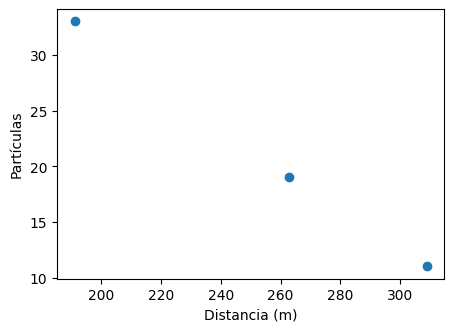

In [6]:
fig1 = plt.figure(figsize=(5, 3.5))
ax1 = fig1.subplots()
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Partículas')
ax1.plot(xdata, ydata, ls='none', marker='o', color='tab:blue', label='Datos')
plt.show()

## Modelo

Distancia de referencia

In [7]:
x0 = 250

In [8]:
def modelo(x, theta):
    S0 = theta[0]
    beta = theta[1]
    return S0 * np.power(x/x0, -beta)

## Función de costo

$J(S_{0}, \beta) = 2 \, \sum_i \left[ (\mu_i(S_{0}, \beta)-y_i) - k_i \log(\mu_i(S_{0}, \beta) / y_i) \right]$

In [9]:
def funcion_costo(theta, xdata, ydata):
        costo = np.zeros_like(theta[0])
        for (x1, y1) in zip(xdata, ydata):
            mu1 = modelo(x1, theta)
            costo += (mu1-y1) - y1 * np.log(mu1/y1)
        return 2*costo

In [10]:
J = lambda theta: funcion_costo(theta, xdata, ydata)

## Ajuste

In [11]:
res = minimize(J, x0=(30, 2))
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.32967858568820096
        x: [ 1.909e+01  2.103e+00]
      nit: 11
      jac: [-9.835e-07  8.643e-07]
 hess_inv: [[ 3.428e+00 -3.315e-01]
            [-3.315e-01  1.930e-01]]
     nfev: 36
     njev: 12

## Parámetros

In [12]:
theta_est = res.x
cova = 2*res.hess_inv
error = np.sqrt( np.diagonal(cova) )
rho = cova[0][1]/(error[0]*error[1])
print(f'S₀ = {theta_est[0]:.1f} ± {error[0]:.1f}')
print(f'β = {theta_est[1]:.2f} ± {error[1]:.2f}')
print(f'ρ = {rho:.2f}')

S₀ = 19.1 ± 2.6
β = 2.10 ± 0.62
ρ = -0.41


## Dibujar ajuste

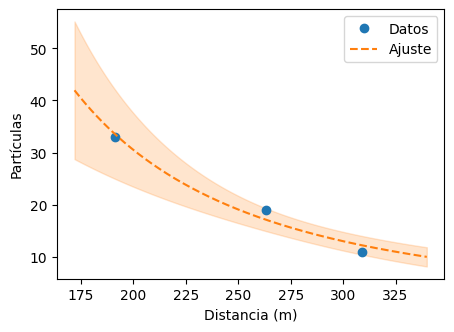

In [13]:
fig1 = plt.figure(figsize=(5, 3.5))
ax1 = fig1.subplots()
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Partículas')
ax1.plot(xdata, ydata, ls='none', marker='o', color='tab:blue', label='Datos')

# ajuste
x = np.linspace( xdata.min()*0.9, xdata.max()*1.1, 256)
mu_est = modelo(x, theta_est)

# banda de error
grad_theta1 = mu_est/theta_est[0]
grad_theta2 = mu_est*np.log(x/x0)
grad = np.column_stack( (grad_theta1, grad_theta2) )
sigma_mu_est = sda.fit_errors(grad, cova)
ax1.fill_between(x, mu_est-sigma_mu_est, mu_est+sigma_mu_est, color='tab:orange', alpha=0.2)

ax1.plot(x, mu_est, color='tab:orange', ls='--', label='Ajuste')
ax1.legend(fontsize='medium')
plt.show()

## Bondad del ajuste

In [14]:
chi2_min = res.fun
ndof = len(xdata) - len(theta_est)
pvalor = chi2.sf(chi2_min, ndof)
print(f'χ²min = {chi2_min:.2f}')
print(f'ndof = {ndof}')
print(f'pvalor = {pvalor*100:.1f}%')

χ²min = 0.33
ndof = 1
pvalor = 56.6%
